In [19]:
import pandas as pd
df = pd.read_excel('parking_data.xlsx')
df.drop(['Schlossberg'],axis=1,inplace=True)

In [20]:
df.loc[df['Ambahnhof'] > 278, 'Ambahnhof'] = 278
df['Ambahnhof'] = df['Ambahnhof']/278
df['Date']=pd.to_datetime(df['Date'], format='%Y/%m/%d %H:%M:%S')
df = df.sort_values(by='Date',ascending=True)

#round to hour
#df['Date'] = df['Date'].dt.floor('h')

df = df.drop_duplicates(subset = "Date")


In [21]:
# Feature engineering with the date
df['Date'] = df['Date'].astype('datetime64[ns]')
df['Date'] = df['Date'].dt.round('5min')  
df['Weekend'] = ((df.Date.dt.dayofweek) // 5 == 1).astype(float)
df['Weekday'] = df['Date'].apply(lambda x: x.weekday())
df[['Year','Month','Day','Hour']] = pd.DataFrame([(x.year, x.month, x.day,x.hour) for x in df['Date']])


In [22]:
df=df.dropna(subset=['Year'])




In [23]:
df.isnull().value_counts()

Date   Ambahnhof  Weekend  Weekday  Year   Month  Day    Hour 
False  False      False    False    False  False  False  False    550151
dtype: int64

In [24]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['Date', 'Ambahnhof']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

467628 82523


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from prophet import Prophet
from prophet.plot import plot_plotly

			
feature_columns = [
    'Weekend',
    'Weekday',
    'Year',
    'Month',
    'Day',
    'Hour'

]
target_column = ['Ambahnhof']

train_size = int(0.85 * len(df))

multivariate_df = df[['Date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5,6,7]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5,6,7]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,Weekend,Weekday,Year,Month,Day,Hour
0,2016-06-21 08:05:00,0.140288,0.0,1,2016.0,6.0,21.0,8.0
1,2016-06-21 08:10:00,0.122302,0.0,1,2016.0,6.0,21.0,8.0
2,2016-06-21 08:15:00,0.107914,0.0,1,2016.0,6.0,21.0,8.0
3,2016-06-21 08:20:00,0.104317,0.0,1,2016.0,6.0,21.0,8.0
4,2016-06-21 08:25:00,0.104317,0.0,1,2016.0,6.0,21.0,8.0


In [26]:
x_valid.head()

,ds,Weekend,Weekday,Year,Month,Day,Hour
499415,2021-03-17 05:00:00,0.0,2,2021.0,7.0,5.0,16.0
499416,2021-03-17 05:05:00,0.0,2,2021.0,7.0,5.0,16.0
499417,2021-03-17 05:10:00,0.0,2,2021.0,7.0,5.0,16.0
499418,2021-03-17 05:15:00,0.0,2,2021.0,7.0,5.0,16.0
499419,2021-03-17 05:20:00,0.0,2,2021.0,7.0,5.0,16.0


In [27]:
# Train the model
model = Prophet()
model.add_regressor('Weekend')
model.add_regressor('Weekday')
model.add_regressor('Year')
model.add_regressor('Month')
model.add_regressor('Day')
model.add_regressor('Hour')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6dqb2jpy/n1_rxw32.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6dqb2jpy/d7hpbxi0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53097', 'data', 'file=/tmp/tmp6dqb2jpy/n1_rxw32.json', 'init=/tmp/tmp6dqb2jpy/d7hpbxi0.json', 'output', 'file=/tmp/tmp6dqb2jpy/prophet_model2p24tbdp/prophet_model-20221023121942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:19:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:46:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 0.24482889906758648


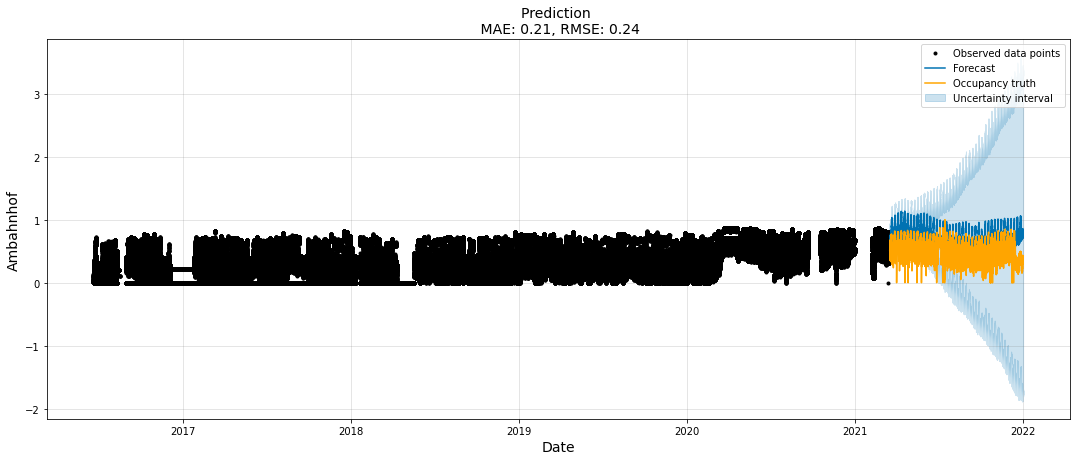

In [31]:
# Plot the forecast
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Occupancy truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Ambahnhof', fontsize=14)

plt.show()

In [30]:
from prophet.plot import plot_plotly
import matplotlib.pyplot as plt

future = model.make_future_dataframe(periods=100)
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
plot_plotly(model, forecast)

ValueError: ignored